In [1]:
import pandas as pd
import geopandas as gpd
import numpy
import pulp
import matplotlib.pyplot as plt
import folium
import spopt
from spopt.locate import LSCP, PMedian
import os

try:
    import routingpy
except ImportError:
    ! pip install routingpy
    import routingpy

from routingpy import OSRM, Google, MapboxOSRM

import warnings
with warnings.catch_warnings():
     warnings.simplefilter("ignore")

# import shapely
# from shapely.geometry import shape, Point
# import json

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

### Problem Formulation: 
Minimize Stations needed to cover all neighborhoods

##### Decision Variables
$Y_{j} \in \{0, 1 \}$: this binary variable is equal to 1 if we build a station at candidate location $j \in J$; and 0 otherwise.

##### Objective Function

\begin{equation}
\text{Min} \quad S = \sum_{j \in J}  Y_{j}
\tag{1}
\end{equation}

$s.t.$

\begin{equation}
\sum_{j \in N_i} Y_{j} \geq 1 \quad \forall i \in I
\tag{2}
\end{equation}

\begin{equation}
Y_{j} \in \{0, 1 \} \quad \forall j \in J
\tag{3}
\end{equation}

$where$

$i \in I$: index of neighborhood of interest (OA centroids)

$j \in J$: index of candidate station locations.

$N_i = \{j|d_{i,j} \leq T \}$: set of stations $j$ within a $S$ travel time of neighborhood $i$. Therefore, $N_{i} \subseteq J \quad \forall i \in I$, where:

- $d_{i,j}$: shortest travel time between neighborhood i and candidate station j (input parameter)

- $T \in \mathbb{Z+}$: maximum time needed to reach a station (input parameter)



#### Define all neighborhoods (OA centroids)

In [2]:
# Load geojson file with geopandas:
oa = gpd.read_file(os.path.join('data','oa.geojson'), driver='GeoJSON')
print(oa.crs)

EPSG:4326


#### Define all candidate stations locations

In [3]:
# Load geojson file with geopandas:
candidates = gpd.read_file(os.path.join('data','candidates.geojson'), driver='GeoJSON')
print(candidates.crs)

EPSG:4326


In [4]:
# Set predefined locations:
candidates["predefined_loc"] = 0
candidates.loc[(0,20,30), "predefined_loc"] = 1
candidates

,fid,distance,angle,predefined_loc,geometry
0,1,0.0,100.375934,1,POINT (-0.10017 51.49510)
1,2,250.0,104.207241,0,POINT (-0.09668 51.49457)
2,3,500.0,85.546935,0,POINT (-0.09318 51.49419)
3,4,750.0,89.372677,0,POINT (-0.08959 51.49423)
4,5,1000.0,123.621900,0,POINT (-0.08601 51.49407)
5,6,1250.0,138.196924,0,POINT (-0.08335 51.49256)
6,7,1500.0,133.078313,0,POINT (-0.08120 51.49077)
7,8,1750.0,131.089312,0,POINT (-0.07859 51.48922)
8,9,2000.0,129.100611,0,POINT (-0.07591 51.48773)
9,10,2250.0,117.313109,0,POINT (-0.07285 51.48656)


In [33]:
m = folium.Map(location=[51.48, -0.05], zoom_start=13,tiles="cartodbdark_matter")

# Map candidates centroids
cand_fg = folium.FeatureGroup("Candidates").add_to(m)
corridor_fg = folium.FeatureGroup("Corridor").add_to(m)
cand = []
cand_loc = []

for i, row in candidates.iterrows():
    folium.CircleMarker(
        location=[row["geometry"].y, row["geometry"].x],
        radius=3,
        fill=True,
        fill_opacity=0.3,
        popup=folium.Popup(f'Stop #{row["fid"]}'),
        color="red"
    ).add_to(cand_fg)
    cand.append({"name": f'Stop #{row["fid"]}', "idx": i})
    cand_loc.append([row["geometry"].y, row["geometry"].x])

# Draw a line connecting the candidates with a for loop
folium.PolyLine(
    locations=cand_loc,
    color="red", 
    weight=2
    ).add_to(corridor_fg)

# Map neighbourhoods (OA centroids)
nbh_fg = folium.FeatureGroup("Neighbourhood (OA)").add_to(m)
nbh = []
nbh_loc = []

for i, row in oa.iterrows():
    folium.CircleMarker(
        location=[row["geometry"].y, row["geometry"].x],
        radius=0.01,
        # No line
        linecolor=None,
        fill=False,
        fill_opacity=0.1,
        popup=folium.Popup(f'{row["code"]}\nPop: {row["population"]:.0f}\n {row["oac_supe_1"]}'),
        color="white"
    ).add_to(nbh_fg)
    nbh.append({"name": row["code"], "idx": i})
    nbh_loc.append([row["geometry"].y, row["geometry"].x])

m.add_child(folium.LayerControl(position="topleft"))

m

#### Computing the Distance (Routing) Matrix

In [6]:
# Create a client for OSRM service
client = OSRM(base_url="http://routing.openstreetmap.de/routed-foot/")


In [7]:
# Split source indices into chunks of 150
source_indices = [i["idx"] for i in nbh]
chunks = [source_indices[i:i + 150] for i in range(0, len(source_indices), 150)]

In [8]:
time_matrix_set = []
for idx, chunk in enumerate(chunks):
    all_locations = nbh_loc[chunk[0]:chunk[-1]+1] + cand_loc
    all_locations = [[x, y] for y, x in all_locations]
    target_indices = [i for i in range(len(all_locations)-len(chunk))]
    # Get travel time matrix
    osrm_routing_matrix = client.matrix(
        dry_run=False,
        locations=all_locations,
        #source is a list from 0 to 149
        sources=[i for i in range(len(chunk))],
        destinations=target_indices,
        )
    duration = numpy.array(osrm_routing_matrix.durations)
    print(f'Matrix {idx+1}/{len(chunks)} has a dimension of {duration.shape}')
    time_matrix_set.append(duration)

Matrix 1/5 has a dimension of (150, 31)
Matrix 2/5 has a dimension of (150, 31)
Matrix 3/5 has a dimension of (150, 31)
Matrix 4/5 has a dimension of (150, 31)
Matrix 5/5 has a dimension of (87, 31)


In [9]:
# Merge all time matrices in time_matrix_set into one
time_matrix = numpy.concatenate(time_matrix_set, axis=0)
print(f'Final matrix has a dimension of {time_matrix.shape}')
time_matrix

Final matrix has a dimension of (687, 31)


array([[   0. ,  195.2,  548. , ..., 1078.1, 1100. ,  780.8],
       [ 195.2,    0. ,  736.1, ...,  868.4,  965.3,  646.1],
       [ 548. ,  736.1,    0. , ..., 1450.6, 1428.3, 1026.3],
       ...,
       [1864.6, 2079.1, 1664.8, ..., 2075.8, 1405.3, 1471.6],
       [1744.3, 1958.8, 1544.5, ..., 1955.5, 1285. , 1351.3],
       [1580.3, 2346.1, 1697.1, ..., 1618.7, 1106.5, 1095.3]])

#### Solving the LSCP

In [10]:
# Iterate t from 600 to 3000
cols= ["service_radius", "num_stations"]
solution_list = []
solver = pulp.COIN_CMD(msg=False)

for t in range(600, 3000, 10):
    # Create and solve an LSCP instance
    lscp = LSCP.from_cost_matrix(
        time_matrix,
        t,
        predefined_facilities_arr=numpy.array(candidates["predefined_loc"])
        )
    try:
        lscp = lscp.solve(solver)
        solution_list.append([t, lscp.problem.objective.value()])
    except:
        pass    

In [11]:
# Write into datafram and record Step change in the number of stations
solution_df = pd.DataFrame(solution_list, columns=cols)
solution_df["step_change"] = solution_df["num_stations"].diff().fillna(0).abs()
solution_df.loc[0, "step_change"] = 1
solution_df.tail()

,service_radius,num_stations,step_change
115,2950,3.0,0.0
116,2960,3.0,0.0
117,2970,3.0,0.0
118,2980,3.0,0.0
119,2990,3.0,0.0


Text(1600, 5, 'Infeasible')

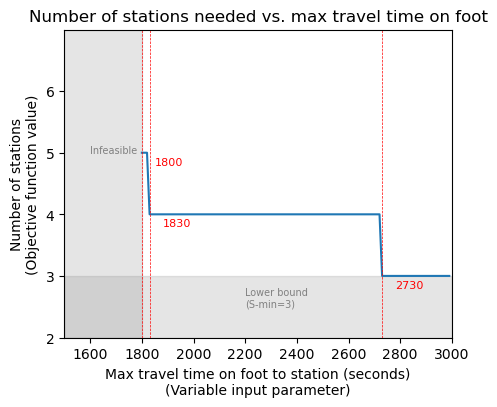

In [44]:
# Plot the number of stations needed vs. max walking distance
ax = solution_df.plot(x="service_radius", y="num_stations", figsize=(5, 4))
ax.set_ylabel("Number of stations\n(Objective function value)")
ax.set_xlabel("Max travel time on foot to station (seconds)\n(Variable input parameter)")
ax.set_title("Number of stations needed vs. max travel time on foot")
ax.legend().set_visible(False)
ax.set_yticks(range(0,7, 1)) # Set y axis ticks to be integers
ax.set_ylim(2, 7) # Set y axis range
ax.set_xlim(1500, 3000) # Set x axis range

# # Add vertical line where step change occurs
for idx, row in solution_df.iterrows():
    if row["step_change"] != 0:
        ax.axvline(x=row["service_radius"], color="red", linestyle="--", linewidth=0.5)
        ax.text(
            x=row["service_radius"]+50,
            y=row["num_stations"]-0.2,
            s=f'{row["service_radius"]:.0f}',
            color="red",
            fontsize=8
        )

# Add shaded area outside of x = 3 and x= 7
ax.axhspan(2, 3, alpha=0.2, color='grey')
ax.axvspan(1500, 1800, alpha=0.2, color='grey') 

# Add text to explain shaded area
ax.text(x=2200, y=2.5, s="Lower bound\n(S-min=3)", fontsize=7, color="grey")
ax.text(x=1600, y=5, s="Infeasible", fontsize=7, color="grey")

In [13]:
# Rerun the model with t = 1830 seconds

t = 1830 # 30.5 minutes
solver = pulp.COIN_CMD(msg=False)
lscp = LSCP.from_cost_matrix(
        time_matrix,
        t,
        predefined_facilities_arr=numpy.array(candidates["predefined_loc"]),
        name="LSCP-min-station"
        )
lscp = lscp.solve(solver)
print(f'With a max walking distance of {t} seconds ({t/60:.1f} minutes), {lscp.problem.objective.value():.0f} stations are needed.')

With a max walking distance of 1830 seconds (30.5 minutes), 4 stations are needed.


In [45]:
# # Add to the map
# m = folium.Map(location=[51.48, -0.05], zoom_start=13,tiles="cartodbdark_matter")
# chosen_stations_fg = folium.FeatureGroup("Chosen Stations (Min Stations)").add_to(m)
# # allocated_demand_fg = folium.FeatureGroup("Allocated").add_to(m)
# solution = {}
# client_marker_size = 10
# numpy.random.seed(0)
# for i in range(len(candidates)):
#     if lscp.fac2cli[i]:
#         color = "gold"
#         # client locations with associated facility symbology
#         solution[i] = []
#         for j in lscp.fac2cli[i]:
#             solution[i].append(nbh[j])
        
#         # selected candidate facility sites
#         folium.CircleMarker(
#             location=cand_loc[i],
#             radius=client_marker_size,
#             fill=True,
#             popup=folium.Popup(f"Chosen Station #{i+1}", show=False),
#             color=color,
#         ).add_to(chosen_stations_fg)

# m.add_child(cand_fg)
# m.add_child(corridor_fg)
# m.add_child(nbh_fg)        
# m.add_child(folium.LayerControl(position="topleft"))
# m

In [15]:
# Create a new column in the dataframe candidate to store the index of the selected candidate
candidates["selected_min_station"] = 0
for i in range(len(candidates)):
    if lscp.fac2cli[i]:
        candidates.loc[i, "selected_min_station"] = 1

### Problem Formulation: 
Minimize weighted travel time on foot to station for all neighborhoods

##### Decision Variable

$X_{i,j} \in \{0, 1 \}$: This variable is equal to 1 if we assign neighborhood $i \in I$ to station $j \in J$; and 0 otherwise.

$Y_{j} \in \{0, 1 \}$: This variable is equal to 1 if we build a station at candidate location $j \in J$; and 0 otherwise.

##### Objective Function
 
We want to minimize the total amount of travel time on foot to the nearest station for all neighborhoods.

\begin{equation}
\text{Min} \quad S = \sum_{i \in I}\sum_{j \in J}  a_{i}d_{i,j}X_{i,j}
\tag{4}
\end{equation}

$s.t.$

\begin{equation}
\sum_{j \in J} Y_{j} \leq k \quad 
\tag{5}
\end{equation}

\begin{equation}
\sum_{j \in J} X_{i,j} = 1 \quad \forall i \in I
\tag{6}
\end{equation}

\begin{equation}
X_{i,j} \leq Y_{j} \quad \forall i \in I \quad \forall j \in J
\tag{7}
\end{equation}

\begin{equation}
X_{i,j} \in \{0, 1 \} \quad \forall i \in I \quad \forall j \in J
\tag{8}
\end{equation}

\begin{equation}
Y_{j} \in \{0, 1 \} \quad \forall j \in J
\tag{9}
\end{equation}

$where$

$i \in I$: index of neighborhood of interest (OA centroids)

$j \in J$: index of candidate station locations.

$d_{i,j}$: shortest travel time between neighborhood i and candidate station j (input parameter)

$a_{i}$: population at $i$ (input parameter)

$k$: number of stations to be located (input parameter)

In [16]:
# Population in each OA
ai = numpy.array(oa["population"])

In [17]:
# Create a loop varying k from 1 to 10 and run the model
cols1= ["k", "obj", "mean_dist"]
solution_list1 = []
solver = pulp.COIN_CMD(msg=False)

for k in range(1, 32):
    # Create and solve an instance
    pmedian_from_cm = PMedian.from_cost_matrix(
        time_matrix,
        ai,
        p_facilities=k,
        predefined_facilities_arr=numpy.array(candidates["predefined_loc"]),
        name="p-median-min-time"
)
    try:
        pmedian_from_cm = pmedian_from_cm.solve(solver)
        solution_list1.append([k, pmedian_from_cm.problem.objective.value(), pmedian_from_cm.mean_dist])
    except:
        pass

In [18]:
solution_df1 = pd.DataFrame(solution_list1, columns=cols1)
solution_df1.head(20)

,k,obj,mean_dist
0,3,243069385.5,1016.796981
1,4,179812984.1,752.185632
2,5,160904350.1,673.087880
3,6,147067690.9,615.206986
4,7,140040550.4,585.811366
5,8,134367890.2,562.081748
6,9,130098665.8,544.222920
7,10,127627757.4,533.886726
8,11,125485499.2,524.925327
9,12,123391657.1,516.166461


Text(31.5, 500, 'Upper\nbound\n(k-max=31)')

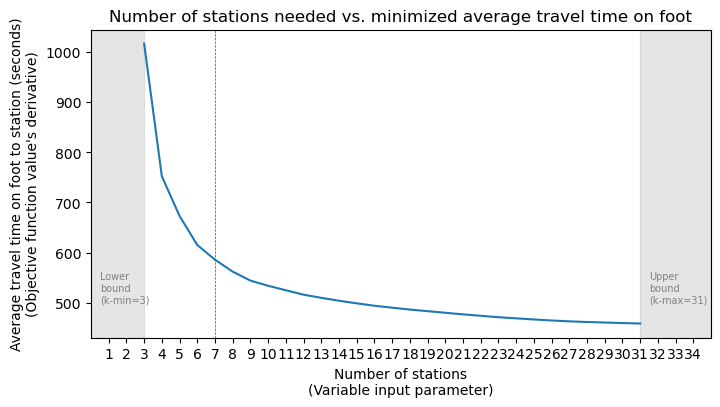

In [42]:
# Plot the number of stations needed vs. max walking distance
ax = solution_df1.plot(x="k", y="mean_dist", figsize=(8, 4))
ax.set_xlabel("Number of stations\n(Variable input parameter)")
ax.set_ylabel("Average travel time on foot to station (seconds)\n(Objective function value's derivative)")
ax.set_title("Number of stations needed vs. minimized average travel time on foot")
ax.legend().set_visible(False)
ax.set_xticks(range(1,35, 1)) # Set x axis ticks to be integers
ax.set_xlim(0, 35)

# Locate the knee point
from kneed import KneeLocator
kn = KneeLocator(solution_df1["k"], solution_df1["mean_dist"], curve="convex", direction="decreasing")
ax.axvline(x=kn.knee-1, color="red", linestyle="--", linewidth=0.5)

# Shade the area outside the range of x = 3 and 31
ax.axvspan(0, 3, alpha=0.2, color='grey')
ax.axvspan(31, 35, alpha=0.2, color='grey')

# Add text to explain shaded area
ax.text(x=0.5, y=500, s="Lower\nbound\n(k-min=3)", fontsize=7, color="grey")
ax.text(x=31.5, y=500, s="Upper\nbound\n(k-max=31)", fontsize=7, color="grey")

In [25]:
# Rerun the model with k=8
k = 7
pmedian_from_cm = PMedian.from_cost_matrix(
    time_matrix,
    ai,
    p_facilities=k,
    predefined_facilities_arr=numpy.array(candidates["predefined_loc"]),
    name="p-median-min-time"
)

# Solve the model using the GLPK
solver = pulp.COIN_CMD(msg=False)
pmedian_from_cm = pmedian_from_cm.solve(solver)

pmp_obj = round(pmedian_from_cm.problem.objective.value(), 0)
pmp_mean = round(pmedian_from_cm.mean_dist, 0)
print(
    f"For an optimal solution, we see the total minimized weighted walking time of {pmp_obj} seconds, "
    f"with an average walking time of {pmp_mean} seconds for each person."
)

For an optimal solution, we see the total minimized weighted walking time of 140040550.0 seconds, with an average walking time of 586.0 seconds for each person.


In [34]:
# Add to the map
m = folium.Map(location=[51.48, -0.05], zoom_start=13,tiles="cartodbdark_matter")
chosen_stations_fg1 = folium.FeatureGroup("Chosen Stations (Min Time)")
solution_pmp = {}
client_marker_size = 10
numpy.random.seed(0)
for i in range(len(candidates)):
    if pmedian_from_cm.fac2cli[i]:
        color = "gold"
        # client locations with associated facility symbology
        solution_pmp[i] = []
        for j in pmedian_from_cm.fac2cli[i]:
            solution_pmp[i].append(nbh[j])
        
        # selected candidate facility sites
        folium.CircleMarker(
            location=cand_loc[i],
            radius=client_marker_size,
            fill=True,
            popup=folium.Popup(f"Chosen Station #{i+1}", show=False),
            color=color,
        ).add_to(chosen_stations_fg1)

m.add_child(chosen_stations_fg)
m.add_child(chosen_stations_fg1)
m.add_child(cand_fg)
m.add_child(corridor_fg)
m.add_child(nbh_fg)   
m.add_child(folium.LayerControl(position="topleft"))
m

In [22]:
# Write chosen candidate locations to dataframe candidates
candidates["selected_min_time"] = 0
for i in range(len(candidates)):
    if pmedian_from_cm.fac2cli[i]:
        candidates.loc[i, "selected_min_time"] = 1
candidates

,fid,distance,angle,predefined_loc,geometry,selected_min_station,selected_min_time
0,1,0.0,100.375934,1,POINT (-0.10017 51.49510),1,1
1,2,250.0,104.207241,0,POINT (-0.09668 51.49457),0,1
2,3,500.0,85.546935,0,POINT (-0.09318 51.49419),0,1
3,4,750.0,89.372677,0,POINT (-0.08959 51.49423),0,1
4,5,1000.0,123.621900,0,POINT (-0.08601 51.49407),0,1
5,6,1250.0,138.196924,0,POINT (-0.08335 51.49256),0,1
6,7,1500.0,133.078313,0,POINT (-0.08120 51.49077),0,1
7,8,1750.0,131.089312,0,POINT (-0.07859 51.48922),0,1
8,9,2000.0,129.100611,0,POINT (-0.07591 51.48773),0,1
9,10,2250.0,117.313109,0,POINT (-0.07285 51.48656),0,1
